### How to run Metrcs on WFD area only using Feasture-based OpSims
Since featured-based OpSim scheduler no longer uses fixed tiles in the sky to plan observations, the WFD footprint can't be easily defined. With the feature-based opsim, there are two ways to run metrics on 'WFD' observations, the first one is introduced in this notebook and another is mentioned in [DDF_Other_FootPrint.ipynb](./03_DDF_Other_FootPrint.ipynb). More in-depth discussion on this topic can be found in this [thread](https://community.lsst.org/t/wfd-metrics-with-the-fbs-output/3970).

The trick introduced here is to define a `HealpixSubsetSlicer` which uses a customized mask to run metric on the WFD region only. This notebook is merely a replicate of the notebook [here](https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/WFD%20footprint%20demo.ipynb) 

In [1]:
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import rubin_sim MAF python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as mb
import rubin_sim.maf.batches as batches

# footprint utils
from rubin_sim.scheduler.utils import footprints

# import convenience functions for MAF analysis on SciServer
from opsimUtils import *

# print version
import rubin_sim
rubin_sim.__version__

'0.7.1.dev169+g40b47c7'

In [3]:
# specify path to the opsim database and create database object
dbfile = '/home/idies/workspace/lsst_cadence/FBS_2.0_v2/baseline/baseline_v2.0_10yrs.db'
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)

In [4]:
# Let's count the visits .. 
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')

In [5]:
# .. over the WFD region - so define the WFD footprint first.
nside = 64
wfd_standard = footprints.WFD_no_gp_healpixels(nside, dec_max=2.5, dec_min=-62.5)
wfd_bigdust = footprints.WFD_no_dust_healpixels(nside, dec_max=12.25, dec_min=-72.5, dust_limit=0.19)

#### 1. Visualize two WFD footprints

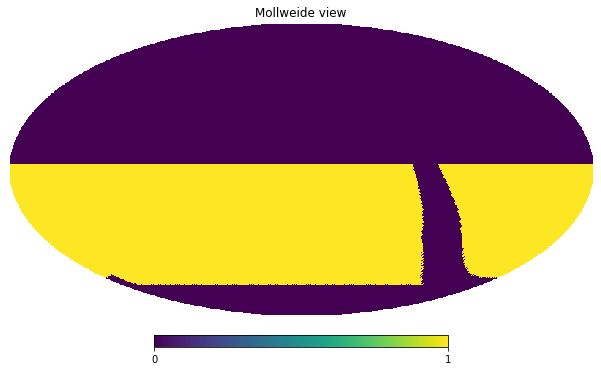

In [6]:
hp.mollview(wfd_standard)

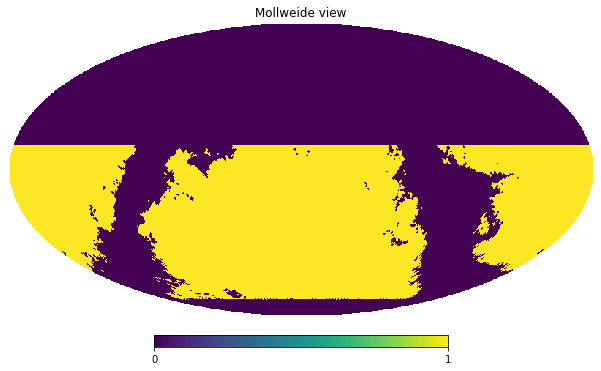

In [7]:
hp.mollview(wfd_bigdust)

#### 2. Use a custom WFD slicer defined using `HealpixSubsectSlicer` to run metric

In [8]:
# we'll use the standard WFD here, as that is what was used with the baseline.
slicer = slicers.HealpixSubsetSlicer(nside, np.where(wfd_standard==1)[0])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [9]:
# And we will skip DD visits, so add a constraint to avoid them.
constraint = 'note not like "DD%"'

In [10]:
bundle = mb.MetricBundle(metric, slicer, constraint, metadata='WFD only')

In [11]:
g = mb.MetricBundleGroup({'0': bundle}, opsdb, outDir=outDir)
g.runAll()

Querying table None with constraint note not like "DD%" for columns ['fieldRA', 'rotSkyPos', 'fieldDec', 'observationStartMJD']
Found 1992714 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
/home/idies/workspace/Storage/ywx649999311/persistent/LSST_Cadence/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 242 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

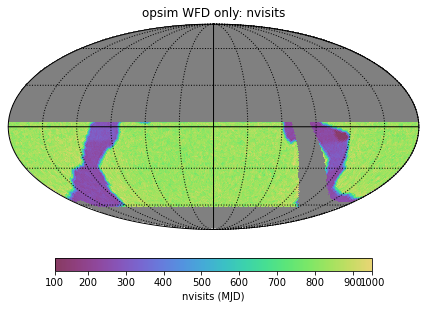

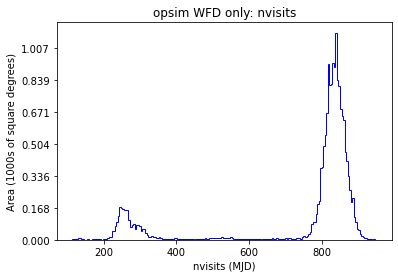

In [12]:
# Let's look at the plots - you get the standard healpix SkyMap, Area Histogram, and powerspectrum. 
bundle.plot()

##### Show summary statistics

In [13]:
# We can also add some summary statistics, which will only be calculated over the WFD footprint (obviously).
bundle.setSummaryMetrics(batches.extendedSummary())
bundle.computeSummaryStats()

In [14]:
# Look at the summary values calculated - pandas DataFrame makes a nice view
pd.DataFrame(bundle.summaryValues, index=['Baseline WFD'])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
Baseline WFD,749.668491,201.53859,829.0,951.0,113.0,0,51,21191,802.0,850.0
